In [22]:
options(repr.plot.width= 8, repr.plot.height=6)
#install.packages('glmnet')
#install.packages('tidymodels')
library(lubridate)
library(tidymodels)
library(tidyverse)

# **Lab 14** : A predictive modeling case study

**What is tidymodels ?**

Much like the tidyverse consists of many core packages, such as ggplot2 and dplyr, tidymodels also consists of several core packages, including

* *rsample:* for sample splitting (e.g. train/test or cross-validation)
* *recipes:* for pre-processing
* *parsnip:* for specifying the model
* *yardstick:* for evaluating the model

In today lab, we are learning how to build a predictive model from beginning to end using tinymodels. The material is based on section 5 in this [article](https://www.tidymodels.org/start/case-study/).

Let's use the hotel booking dataset from [Antonio, Almeida, and Nunes (2019)](https://www.sciencedirect.com/science/article/pii/S2352340918315191?via%3Dihub) to predict if customers would **spend the weekend at hotels** based on the other characteristics of the stays such as which hotel the guests stay at, how much they pay, whether they have children and etc. We use a subset of the booking hotel data by removing rows of which day of arrival are either Saturday or Sunday.

In [ ]:
# load hotel booking dataset
hotels <- 
  read_csv('https://tidymodels.org/start/case-study/hotels.csv') %>%
  mutate(across(where(is.character), as.factor)) 

data <- hotels %>%  filter(!weekdays(arrival_date) %in% c('Saturday', 'Sunday')) %>%
                   mutate(spend_weekend = if_else(stays_in_weekend_nights > 0, TRUE, FALSE)) %>%
                   mutate(spend_weekend = factor(spend_weekend, levels = c(TRUE, FALSE))) %>%
                   select(-stays_in_weekend_nights)
                 
# initial inspection of the data
glimpse(data)

Rows: 50000 Columns: 23
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (11): hotel, children, meal, country, market_segment, distribution_chan...
dbl  (11): lead_time, stays_in_weekend_nights, stays_in_week_nights, adults,...
date  (1): arrival_date

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Rows: 36,347
Columns: 23
$ hotel                          <fct> City_Hotel, City_Hotel, Resort_Hotel, R…
$ lead_time                      <dbl> 217, 2, 143, 136, 47, 56, 80, 130, 27, …
$ stays_in_week_nights           <dbl> 3, 1, 6, 4, 2, 3, 4, 2, 1, 2, 2, 2, 0, …
$ adults                         <dbl> 2, 2, 2, 2, 2, 0, 2, 2, 1, 2, 2, 2, 1, …
$ children                       <fct> none, none, none, none, children, child…
$ meal                           <fct> BB, BB, HB, HB, BB, BB, BB, BB, BB, BB,…
$ country                        <fct> DEU, PRT, ROU, PRT, ESP, ESP, FRA, FRA,…
$ market_segment                 <fct> Offline_TA/TO, Direct, Online_TA, Direc…
$ distribution_channel           <fct> TA/TO, Direct, TA/TO, Direct, Direct, T…
$ is_repeated_guest              <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, …
$ previous_cancellations         <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, …
$ previous_bookings_not_canceled <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, …
$ reserved_room

#### Exercise 1: The first step in any data analysis task is data exploration. Create a plot which shows the relationship between **spend_weekend** and **stays_in_week_nights** ? 

In [ ]:
# [Your answer here]

In [ ]:
#@title Answer to Exercise 1
ggplot(data = data) +
  geom_boxplot(aes(x = spend_weekend, y = stays_in_week_nights)) +
  xlab("Stay weekend") +
  ylab("Number of Weekday Stay") +
  theme_bw()

## DATA SPLITTING & RESAMPLING

The purpose of splitting data into the different sets is to avoid overfitting. A simple yet effective strategy is to divide our data into training, validation and test set. For this case study, let’s reserve 25% of the stays to the test set. For the remaining,  let’s create a single resample called a validation set. In tidymodels, a validation set is treated as a single iteration of resampling. This will be a split from the stays that were not used for testing, which we called hotel_other.

In [ ]:
set.seed(123)

# split data into training, validation and test set
splits      <- initial_split(data, strata = spend_weekend)

hotel_other <- training(splits)
hotel_test  <- testing(splits)
val_set <- validation_split(hotel_other, 
                            strata = spend_weekend, 
                            prop = 0.80)

#### Exercise 2: verify that the percentage of test data is ~25%, and the validation set is ~20% of training data. 

In [ ]:
# [Your answer here]

In [ ]:
#@title Answer to Exercise 2
print(nrow(hotel_test) / (nrow(hotel_other) + nrow(hotel_test)))

print(val_set)
5452 / (21807 + 5452)

[1] 0.2500344
# Validation Set Split (0.8/0.2)  using stratification 
# A tibble: 1 × 2
  splits               id        
  <list>               <chr>     
1 <split [21807/5452]> validation


[1] 0.2000073

## BUILD PREDICTIVE MODELS

### Step 1: specify a predictive model

In today class, we will build a penalized logistic regression classifier. This can be defined in tinymodels with the function logistic_reg(). The agrumemt penalty is specified with tune() function for tuning purposes to be explained shortly.

In [ ]:
lr_mod <- 
  logistic_reg(penalty = tune(), mixture = 1) %>% 
  set_engine("glmnet")

### Step 2: create a recipe

The tidymodels package, recipes, which is designed to help you preprocess your data before training your model. Recipes are built as a series of preprocessing steps, such as:

* converting qualitative predictors to indicator variables (also known as dummy variables),
* transforming data to be on a different scale (e.g., taking the logarithm of a variable),
* transforming whole groups of predictors together,
* extracting key features from raw variables (e.g., getting the day of the week out of a date variable),

In [ ]:
holidays <- c("AllSouls", "AshWednesday", "ChristmasEve", "Easter", 
              "ChristmasDay", "GoodFriday", "NewYearsDay", "PalmSunday")

lr_recipe <- 
  recipe(spend_weekend ~ ., data = hotel_other) %>% 
  step_date(arrival_date) %>% 
  step_holiday(arrival_date, holidays = holidays) %>% 
  step_rm(arrival_date) %>% 
  step_dummy(all_nominal_predictors()) %>% 
  step_zv(all_predictors()) %>% 
  step_normalize(all_predictors())

In the above receipe,

* step_date() creates predictors for the year, month, and day of the week.
* step_holiday() generates a set of indicator variables for specific holidays. Although we don’t know where these two hotels are located, we do know that the countries for origin for most stays are based in Europe.
* step_rm() removes variables; here we’ll use it to remove the original date variable since we no longer want it in the model.

Additionally, all categorical predictors (e.g., distribution_channel, hotel, …) should be converted to dummy variables, and all numeric predictors need to be centered and scaled.

* step_dummy() converts characters or factors (i.e., nominal variables) into one or more numeric binary model terms for the levels of the original data.
* step_zv() removes indicator variables that only contain a single unique value (e.g. all zeros). This is important because, for penalized models, the predictors should be centered and scaled.
* step_normalize() centers and scales numeric variables.

### Step 3: create a workflow

We will want to use our recipe across several steps as we train and test our model. We will:

* Process the recipe using the training set: This involves any estimation or calculations based on the training set. For our recipe, the training set will be used to determine which predictors should be converted to dummy variables and which predictors will have zero-variance in the training set, and should be slated for removal.

* Apply the recipe to the training set: We create the final predictor set on the training set.

* Apply the recipe to the test set: We create the final predictor set on the test set. Nothing is recomputed and no information from the test set is used here; the dummy variable and zero-variance results from the training set are applied to the test set.

To simplify this process, we can use a model workflow, which pairs a model and recipe together. 

In [ ]:
lr_workflow <- 
  workflow() %>% 
  add_model(lr_mod) %>% 
  add_recipe(lr_recipe)

### Step 4: tune the model & evaluate its performance metrics.

Recall in Step 1 that penalty argument in logistic_reg() is specified with tune(). The penalty is a hyperparameter used by penalized logistic regression model. We tune the model hyperparameters to avoid overfitting. To tune penalty, we first create a grid of possible values.

In [ ]:
lr_reg_grid <- tibble(penalty = 10^seq(-4, -1, length.out = 30)) # create the grid of possible values to tune penalty hyperparameter

lr_reg_grid %>% top_n(-5) # lowest penalty values

lr_reg_grid %>% top_n(5) # highest penalty values

Selecting by penalty


penalty
<dbl>
0.0001000000
0.0001268961
0.0001610262
0.0002043360
0.0002592944


Selecting by penalty


penalty
<dbl>
0.03856620
0.04893901
0.06210169
0.07880463
0.10000000


Next, let’s use tune::tune_grid() to train these 30 penalized logistic regression models. We’ll also save the validation set predictions (via the call to control_grid()) so that diagnostic information can be available after the model fit. The area under the ROC curve will be used to quantify how well the model performs across a continuum of event thresholds 

In [ ]:
lr_res <- 
  lr_workflow %>% 
  tune_grid(val_set,
            grid = lr_reg_grid,
            control = control_grid(save_pred = TRUE),
            metrics = metric_set(roc_auc))

It might be easier to visualize the validation set metrics by plotting the area under the ROC curve against the range of penalty values. The area under a receiver operating characteristic (ROC) curve, abbreviated as AUC, is a single scalar value that measures the overall performance of a binary classifier (Hanley and McNeil 1982). The AUC value is within the range [0.5, 1.0], where the minimum value represents the performance of a random classifier and the maximum value would correspond to a perfect classifier (e.g., with a classification error rate equivalent to zero).

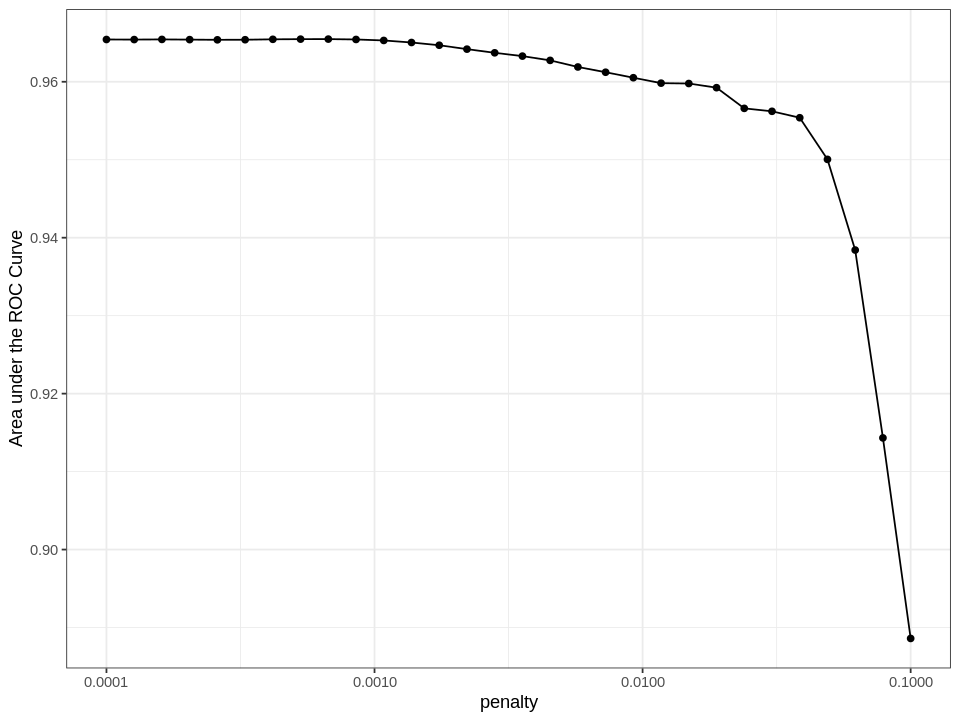

In [ ]:
lr_plot <- 
  lr_res %>% 
  collect_metrics() %>% 
  ggplot(aes(x = penalty, y = mean)) + 
  geom_point() + 
  geom_line() + 
  ylab("Area under the ROC Curve") +
  scale_x_log10(labels = scales::label_number()) +
  theme_bw()

lr_plot 


In [ ]:
top_models <-
  lr_res %>% 
  show_best("roc_auc", n = 15) %>% 
  arrange(penalty) 
top_models

penalty,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
0.0001000000,roc_auc,binary,0.9654189,1,NA,Preprocessor1_Model01
0.0001268961,roc_auc,binary,0.9654104,1,NA,Preprocessor1_Model02
0.0001610262,roc_auc,binary,0.9654304,1,NA,Preprocessor1_Model03
0.0002043360,roc_auc,binary,0.9654042,1,NA,Preprocessor1_Model04
0.0002592944,roc_auc,binary,0.9653791,1,NA,Preprocessor1_Model05
0.0003290345,roc_auc,binary,0.9653906,1,NA,Preprocessor1_Model06
0.0004175319,roc_auc,binary,0.9654431,1,NA,Preprocessor1_Model07
0.0005298317,roc_auc,binary,0.9654656,1,NA,Preprocessor1_Model08
0.0006723358,roc_auc,binary,0.9654708,1,NA,Preprocessor1_Model09


This plots shows us that model performance is generally better at the smaller penalty values. This suggests that the majority of the predictors are important to the model. We use select_best() to pick the best penalty hyperparameter value and visualize the validation set ROC curve:

In [ ]:
lr_best <- 
  lr_res %>% 
  select_best()

lr_best

penalty,.config
<dbl>,<chr>
0.0006723358,Preprocessor1_Model09


Warning message:
“Returning more (or less) than 1 row per `summarise()` group was deprecated in
dplyr 1.1.0.
ℹ Please use `reframe()` instead.
ℹ When switching from `summarise()` to `reframe()`, remember that `reframe()`
  always returns an ungrouped data frame and adjust accordingly.
ℹ The deprecated feature was likely used in the yardstick package.
  Please report the issue at <https://github.com/tidymodels/yardstick/issues>.”


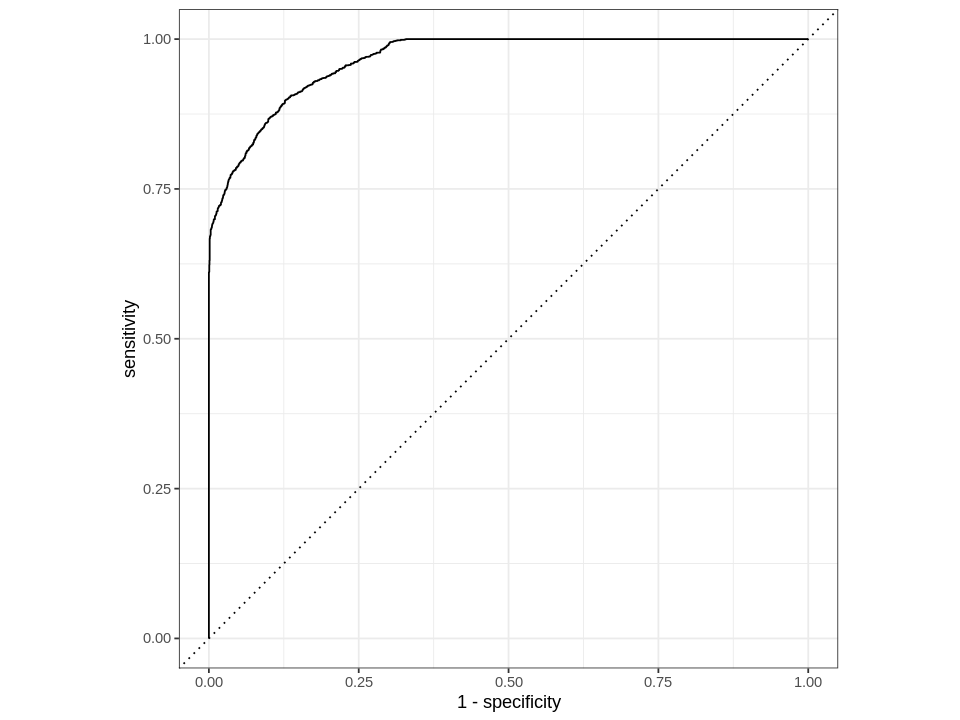

In [ ]:
lr_auc <- 
  lr_res %>% 
  collect_predictions(parameters = lr_best) %>% 
  roc_curve(spend_weekend, .pred_TRUE) %>% 
  mutate(model = "Logistic Regression")

autoplot(lr_auc)


An ROC curve (receiver operating characteristic curve) is a graph showing the performance of a classification model at all classification thresholds. This curve plots two parameters: Sentivity and 1 - specificity. 

* Sensitivity is the metric used for evaluating a model's ability to predict the true positives of each available category.
* Specificity is the the model's ability to predict a true negative of each category available. 

The ROC curve shows the trade-off between sensitivity and specificity. Classifiers that give curves closer to the top-left corner indicate a better performance. 

## THE LAST FIT

Now that we picked the best logic regression penalized value. The last step is to fit the final model on all the rows of data not originally held out for testing (both the training and the validation sets combined), and then evaluate the model performance one last time with the held-out test set.

In [ ]:
# the last model
last_lr_mod <- 
  logistic_reg(penalty = 0.00067, mixture = 1) %>% 
  set_engine("glmnet")

# the LR workflow
last_lr_workflow <- 
  lr_workflow %>% 
  update_model(last_lr_mod)

# the last fit
set.seed(345)
last_lr_fit <- 
  last_lr_workflow %>% 
  last_fit(splits)

#### Exercise 3: create AUC-ROC plot for the last fitted model on the test set. How does it compare to performance over validation set in the last section ?

In [ ]:
#[Your answer here]

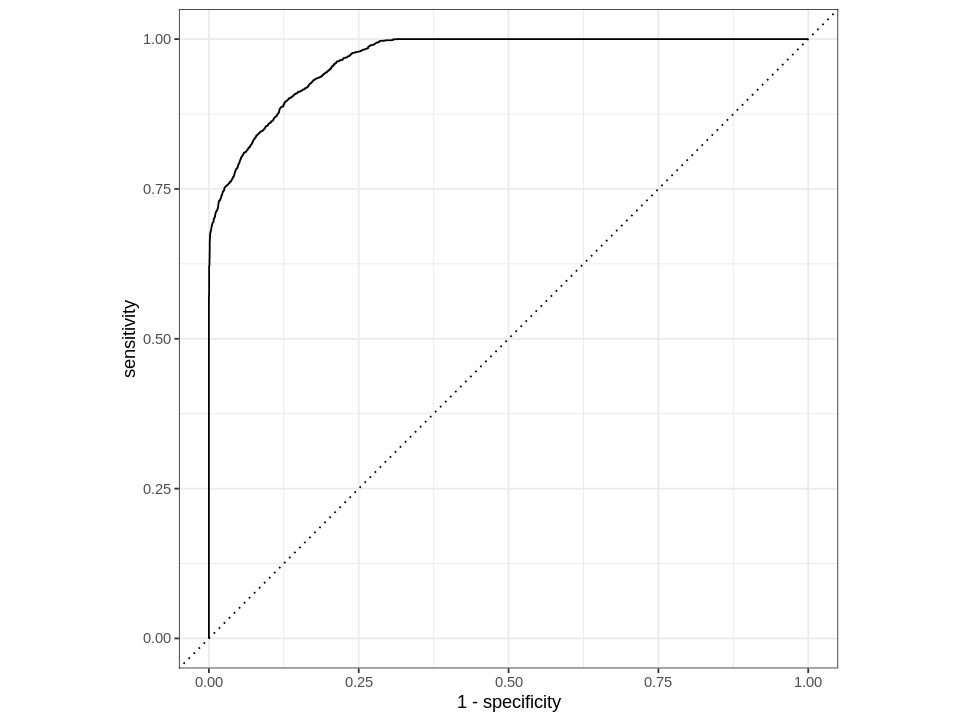

In [ ]:
#@title Answer to Exercise 3
last_lr_fit %>% 
  collect_predictions() %>% 
  roc_curve(spend_weekend, .pred_TRUE) %>% 
  autoplot()

# Performance over the test set is very similar to validation
# set

Finally, we extract the estimated coefficients from the last fitted model and plot them out. As illustrated in the below, stay_in_week_nights and arrival_date are the two most siginifcant features in predicting if customers stay over weeekends.

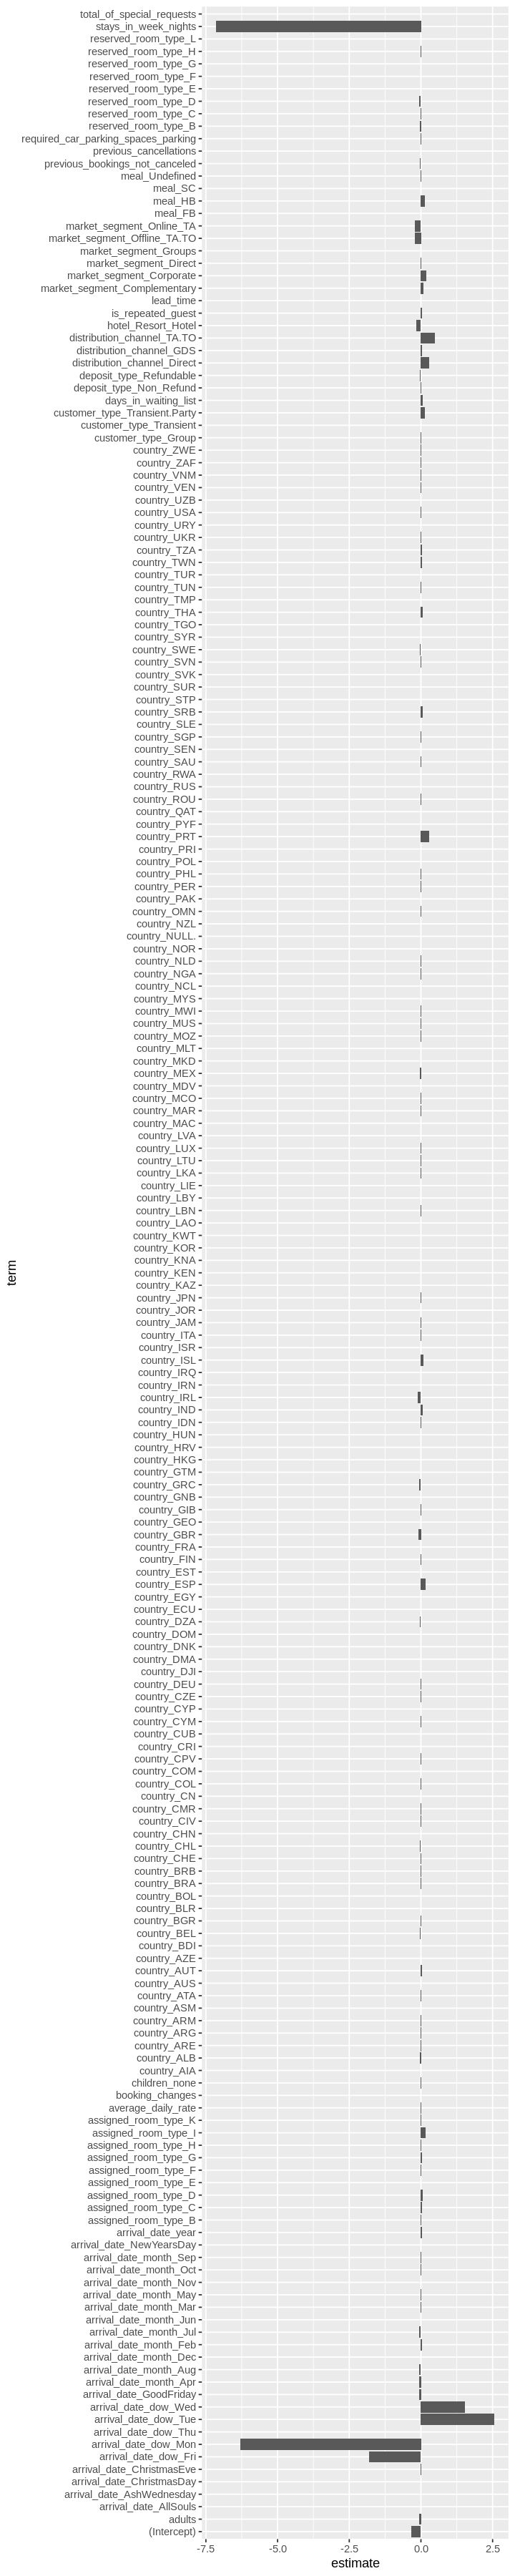

In [ ]:
options(repr.plot.width= 6, repr.plot.height=30)

last_lr_fit %>% 
  extract_fit_parsnip() %>%
  tidy() %>%
  ggplot() + geom_col(aes(y = term, x = estimate))
